In [2]:
import tensorflow as tf
import tensorflow.keras as tk
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"]="6"

# 데이터셋 준비하기

### 데이터셋 불러오기

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

### 데이터셋 정보 확인

In [4]:
print('학습 데이터 ', x_train.shape)
print('테스트 데이터 ', x_test.shape)

학습 데이터  (60000, 28, 28, 1)
테스트 데이터  (10000, 28, 28, 1)


### 데이터 이미지 확인

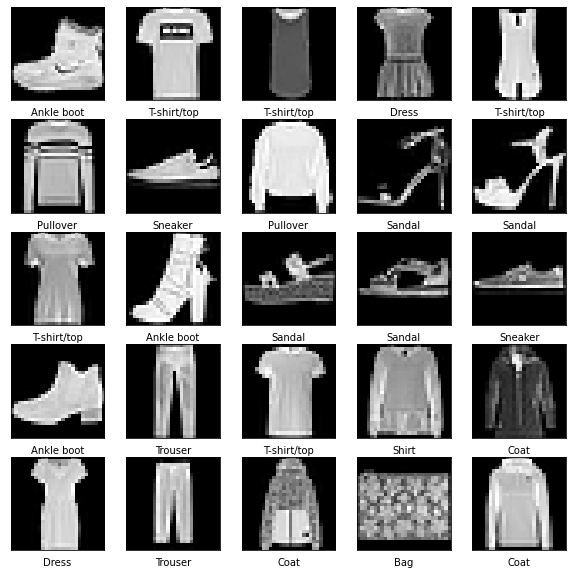

In [4]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 데이터 Normalization

In [5]:
print('최대 픽셀 값', x_train.max())
print('최소 픽셀 값', x_train.min())

최대 픽셀 값 255
최소 픽셀 값 0


In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
print('최대 픽셀 값', x_train.max())
print('최소 픽셀 값', x_train.min())

최대 픽셀 값 1.0
최소 픽셀 값 0.0


In [8]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

2024-02-21 02:33:35.115475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 02:33:35.764216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:63:00.0, compute capability: 8.6


### Batch, Iteration, Epoch 이해하기

- `Batch`
    > 데이터를 통째로 신경망에 입력하게 되면 컴퓨팅 리소스가 매우 많이 필요하며 비효율적임. 이를 해결하고자 데이터 셋을 작은 그룹으로 나눠서 여러번에 나눠 학습을 수행하게 됨. 이때 작은 그룹을 `Batch`, 그룹의 사이즈를 `Batch size`라 함

- `Epoch`
    > `Epoch`은 전체 학습 데이터가 신경망을 통과한 횟수. 15-epoch은 전체 학습 데이터가 신경망에 입력되 순전파와 역전파를 통해 신경망을 15번 통과했다는 것을 의미

- `Iteration`
    > 1-epoch을 마치는데 필요한 미니배치의 갯수



In [9]:
train_ds.shape

AttributeError: 'BatchDataset' object has no attribute 'shape'

# 모델 정의하기

### Dense Layer

Random input 생성

In [ ]:
batch_size = 100
input_dimension = 32
input = tf.random.normal(shape=[100, 32])
print('random input shape: ', input.shape)

Dense layer 정의

In [ ]:
output_dimension = 128
dense_layer = tk.layers.Dense(units=output_dimension, activation='relu')

Dense layer 연산 (forward)

In [ ]:
output = dense_layer(input)
print('output shape: ', output.shape)

### Dense Layer with Image Dataset

- Dense layer의 경우 1차원 데이터만 처리 가능
- 2차원 이미지 데이터를 dense layer가 처리 가능한 1차원 데이터로 변환하기 위해서 Flatten layer 사용

In [ ]:
batch_size = 100
input = x_train[:batch_size]
print('Flattening 적용 전 입력 shape:', input.shape)

In [ ]:
flatten_layer = tk.layers.Flatten()
flatten_input = flatten_layer(input)
print('Flattening 적용 후 입력 shape:', flatten_input.shape)

In [ ]:
output_dimension = 128
dense_layer = tk.layers.Dense(units=output_dimension, activation='relu')
output = dense_layer(flatten_input)
print('output shape: ', output.shape)

### DNN 모델 정의

Dense layer로 구성된 DNN model을 class로 정의

In [ ]:
class dnn_model(tk.Model):
    def __init__(self):
        super(dnn_model, self).__init__(name='dnn')
        self.flatten = tk.layers.Flatten()
        self.dense = tk.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense(x)
        return x

# 모델 학습

### 모델 학습 준비

모델 인스턴스 생성

In [ ]:
model = dnn_model()
input_shape = (1, 28, 28)
model.build(input_shape)
model.summary()

모델 학습을 위한 loss 함수와 optimizer 정의

In [ ]:
# loss 함수
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# optimizer
optimizer = tf.keras.optimizers.Adam()

성능 평가 지표인 평균 loss와 accuracy를 학습 데이터셋과 테스트 데이터셋에 대해서 각각 정의

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### 학습 및 추론 함수 작성

학습에 필요한 gradient 값을 획득하기 위해서 TF에서 제공하는 `GradientTape()` 함수를 활용

`GradientTape()` 활용 예시

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print('dy/dx=2x, ', dy_dx)

학습 함수 정의

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

추론 함수 정의

In [ ]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

모델 학습 및 성능 평가

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

# Quiz

- 위에서 정의한 DNN model은 layer 수의 부족으로 높은 정확도를 달성하는데 어려움이 있음
- 아래의 `dnn_model` class에 dense layer를 추가해서 정확도가 높은 DNN model 만들기

### Hint
- `self.new_layer = tk.layers.Dense(output_dimension, activation='relu')` 와 같이 새로운 dense layer 추가 가능

In [ ]:
class dnn_model(tk.Model):
    def __init__(self):
        super(dnn_model, self).__init__(name='dnn')
        self.flatten = tk.layers.Flatten()
        '''
        TODO: 새로운 dense layer 정의
        '''
        self.dense = tk.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        '''
        TODO: 새로운 모델 연산식 정의
        '''
        x = self.dense(x)
        return x
        
model = dnn_model()

# loss 함수
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# optimizer
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

# Model Selection

### Goal

1. 
2.

### validation dataset 준비 (hold-out cross validation)

### 모델 구조 별 validation accuracy 평가

### 최종 모델 도출